In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.model_selection import train_test_split

sns.set(style='whitegrid')

In [2]:
df = pd.read_csv('FB_dataset.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 19 columns):
Page total likes                                                       500 non-null int64
Type                                                                   500 non-null object
Category                                                               500 non-null int64
Post Month                                                             500 non-null int64
Post Weekday                                                           500 non-null int64
Post Hour                                                              500 non-null int64
Paid                                                                   499 non-null float64
Lifetime Post Total Reach                                              500 non-null int64
Lifetime Post Total Impressions                                        500 non-null int64
Lifetime Engaged Users                                                 500 non-nul

In [4]:
df.head(5)

,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
0,139441,Photo,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,4,79.0,17.0,100
1,139441,Status,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,5,130.0,29.0,164
2,139441,Photo,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,0,66.0,14.0,80
3,139441,Photo,2,12,2,10,1.0,50128,87991,2211,790,1119,61027,32048,1386,58,1572.0,147.0,1777
4,139441,Photo,2,12,2,3,0.0,7244,13594,671,410,580,6228,3200,396,19,325.0,49.0,393


## We want to see if we can predict Total Interactions

Let's identify some useful variables first, before we build our regression model 

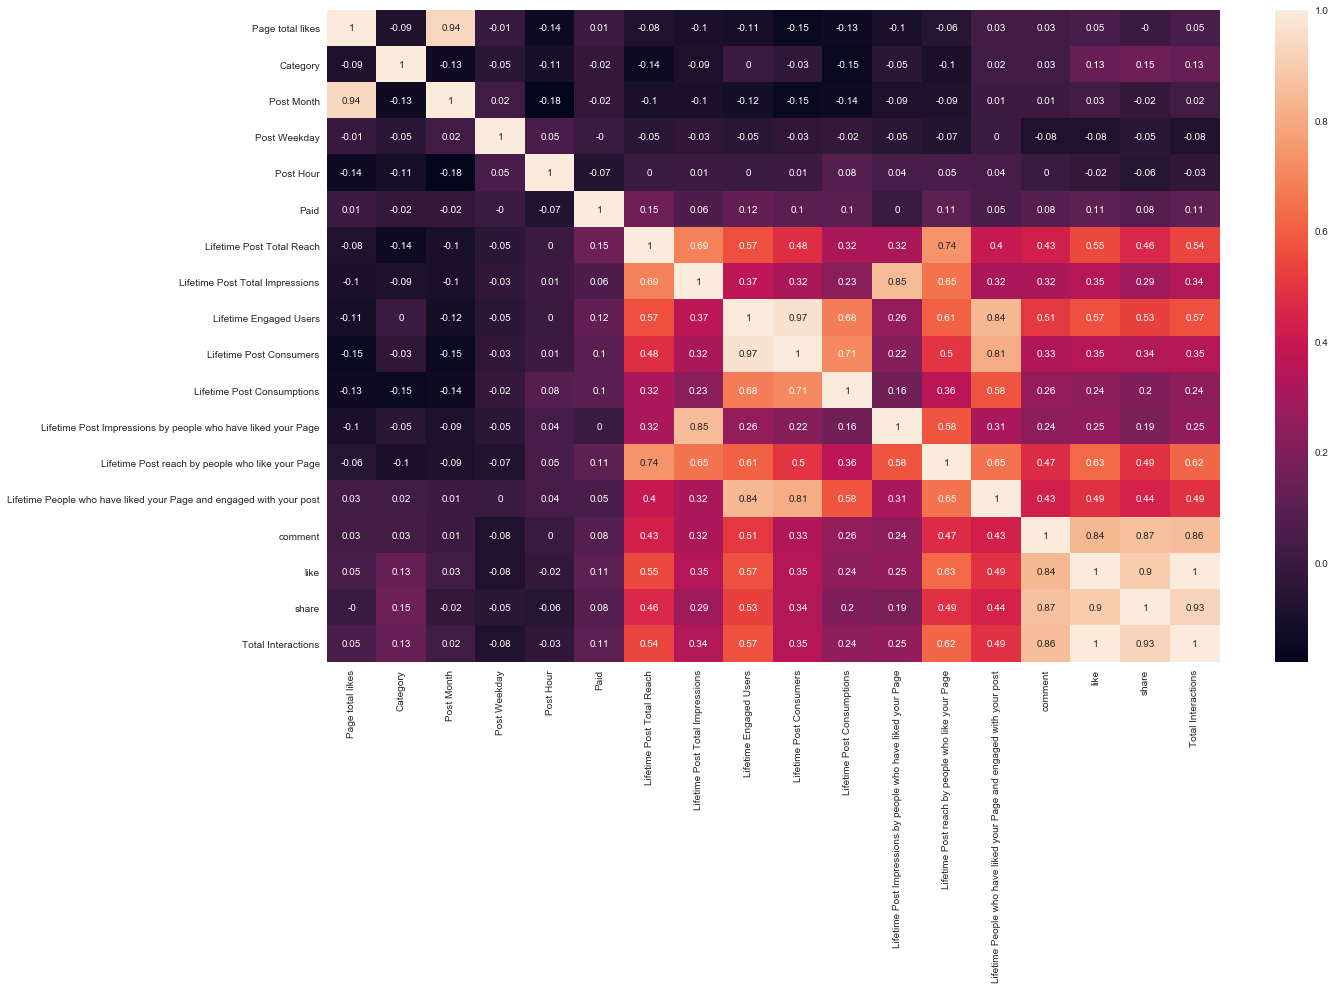

In [11]:
corr = df.corr().round(2) # Create correlation matrix
fig, ax = plt.subplots(figsize=(20,12)) # Create plot
sns.heatmap(corr, annot=True) # Draw heatmap 

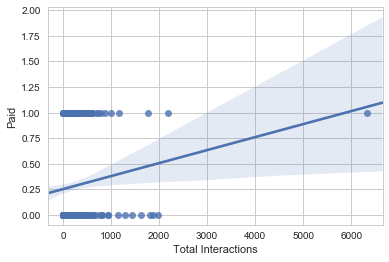

In [6]:
sns.regplot(df['Total Interactions'], df['Paid'])

Out of curiosity, let's see how FB payments vary over the months:

In [180]:
df.groupby('Post Month')['Paid'].count()

Post Month
1     24
2     26
3     36
4     50
5     37
6     49
7     52
8     34
9     36
10    60
11    45
12    50
Name: Paid, dtype: int64

Text(0.5,1,'Number of Paid Ads Being Run Each Month')

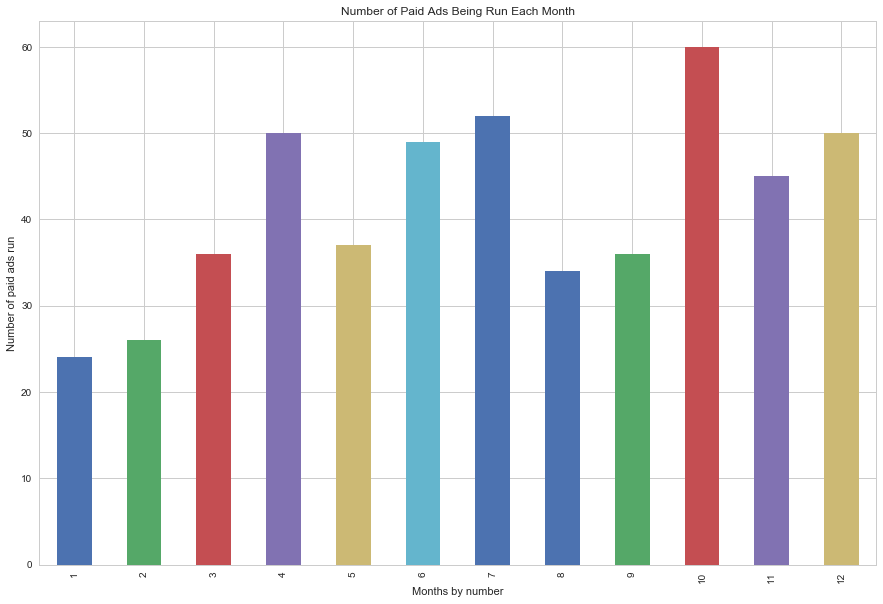

In [181]:
fig, ax = plt.subplots(figsize=(15, 10))
df.groupby('Post Month')['Paid'].count().plot(kind='bar')

plt.xlabel('Months by number')
plt.ylabel('Number of paid ads run')
plt.title('Number of Paid Ads Being Run Each Month')

Is there a most popular day for buying ads?

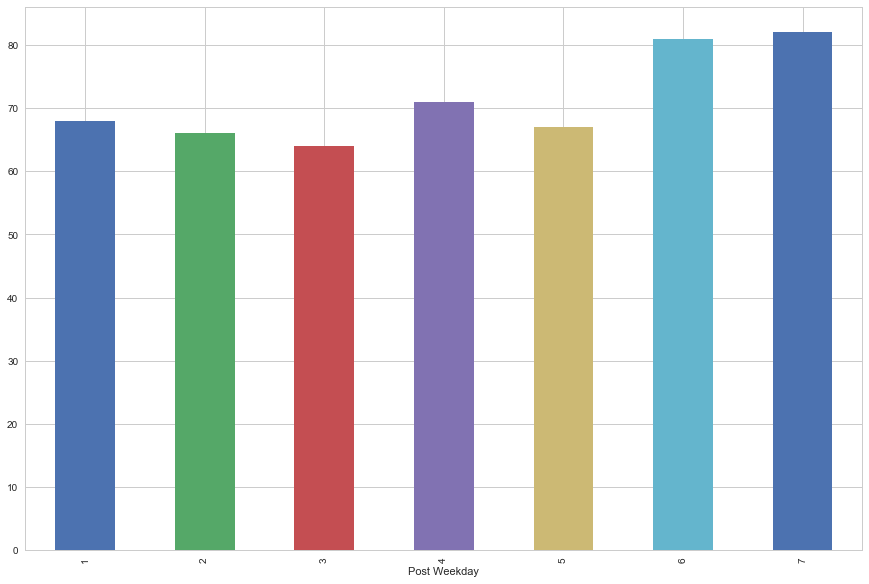

In [182]:
fig = plt.figure(figsize=(15,10))
df.groupby('Post Weekday')['Paid'].count().plot(kind='bar')

Kind of interesting, but not what we're here to do today. Moving on - let's pick some regressors and see if we can model a relationship that predicts Total Interactions

In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 19 columns):
Page total likes                                                       500 non-null int64
Type                                                                   500 non-null object
Category                                                               500 non-null int64
Post Month                                                             500 non-null int64
Post Weekday                                                           500 non-null int64
Post Hour                                                              500 non-null int64
Paid                                                                   499 non-null float64
Lifetime Post Total Reach                                              500 non-null int64
Lifetime Post Total Impressions                                        500 non-null int64
Lifetime Engaged Users                                                 500 non-nul

In [184]:
X = df[['Page total likes', 'Lifetime Engaged Users', 'Lifetime Post Total Reach']]
Y = df['Total Interactions']
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42)

In [185]:
model = sm.OLS(y_train, x_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     Total Interactions   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     147.1
Date:                Tue, 05 Nov 2019   Prob (F-statistic):           7.32e-63
Time:                        01:47:27   Log-Likelihood:                -2695.8
No. Observations:                 375   AIC:                             5398.
Df Residuals:                     372   BIC:                             5409.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Page total likes      

Looking at our results, a few things stand out. Our durbin-watson test of ~2 means we've successfully avoided autocorellation. Looking at our R-Squared and adjusted R-Squared values, we can see they're pretty low. At best, our model has moderate predictive strength. Moreover, we can see that our feature: "Page Total Likes" only has 0 in its confidence interval, meaning it has no predictive power.

That's an interesting finding! We would have expected the total likes of the page to influence the total impressions a post receives. Let's take a look at our residual plot:

Text(0.5,1,'Predicted vs. Actual Target Values')

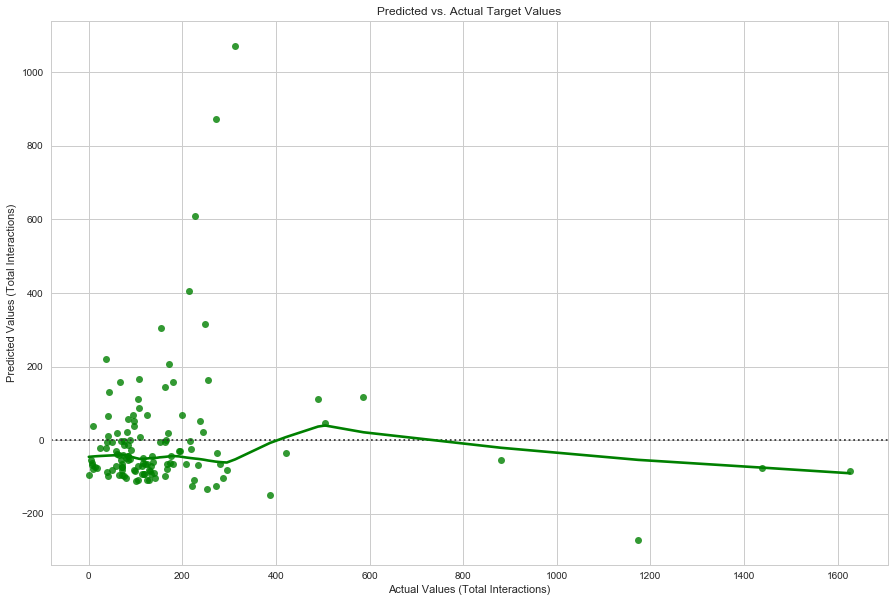

In [186]:
predictions = model.predict(x_test)

fig = plt.figure(figsize=(15,10))
sns.residplot(y_test, predictions, lowess=True, color="g")

plt.xlabel('Actual Values (Total Interactions)')
plt.ylabel('Predicted Values (Total Interactions)')
plt.title('Predicted vs. Actual Target Values')

Looking at our residual plot, we can see that our residual points aren't normally distributed. For one, we can see that some of our predicted values are below 0 - that makes no sense for a variable like Total Interactions (something to keep in mind when dealing with linear regression - it just draws a line). However, we can see we have outlying points arranged in a curve, indicating we must have missed something.

Just to quickly fact check our results - I'm going to quickly validate that Page Total Likes truly doesn't have a relation to Total Post Impressions with another regression test:

In [187]:
x = df['Page total likes']
x_train, x_test, y_train, y_test = train_test_split(x, Y, random_state=24)
model = sm.OLS(y_train, x_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Total Interactions   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     228.9
Date:                Tue, 05 Nov 2019   Prob (F-statistic):           1.09e-40
Time:                        01:47:28   Log-Likelihood:                -2615.0
No. Observations:                 375   AIC:                             5232.
Df Residuals:                     374   BIC:                             5236.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Page total likes     0.0016      0.000     15.131      0.000       0.001       0.002
==============================================================================
Omnibus:                      359.437   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9431.985
Skew:                           4.170   Prob(JB):                         0.00
Kurtosis:                      26.110   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

That confirms our suspicions. Let's move on to trying out some other variables. We can reference our previous heatmap to see if we can find some other good candidates.

In [188]:
df.rename(columns = {'Lifetime Post Impressions by people who have liked your Page':'Total Impressions from Liked Profiles'}, inplace = True) 
df.columns

Index(['Page total likes', 'Type', 'Category', 'Post Month', 'Post Weekday',
       'Post Hour', 'Paid', 'Lifetime Post Total Reach',
       'Lifetime Post Total Impressions', 'Lifetime Engaged Users',
       'Lifetime Post Consumers', 'Lifetime Post Consumptions',
       'Total Impressions from Liked Profiles',
       'Lifetime Post reach by people who like your Page',
       'Lifetime People who have liked your Page and engaged with your post',
       'comment', 'like', 'share', 'Total Interactions'],
      dtype='object')

In [189]:
X = df[['Total Impressions from Liked Profiles', 'Lifetime Engaged Users']]
Y = df['Total Interactions']
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42)

In [190]:
model = sm.OLS(y_train, x_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     Total Interactions   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     200.9
Date:                Tue, 05 Nov 2019   Prob (F-statistic):           6.26e-60
Time:                        01:47:29   Log-Likelihood:                -2705.4
No. Observations:                 375   AIC:                             5415.
Df Residuals:                     373   BIC:                             5423.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

Text(0.5,1,'Predicted vs. Actual Target Values')

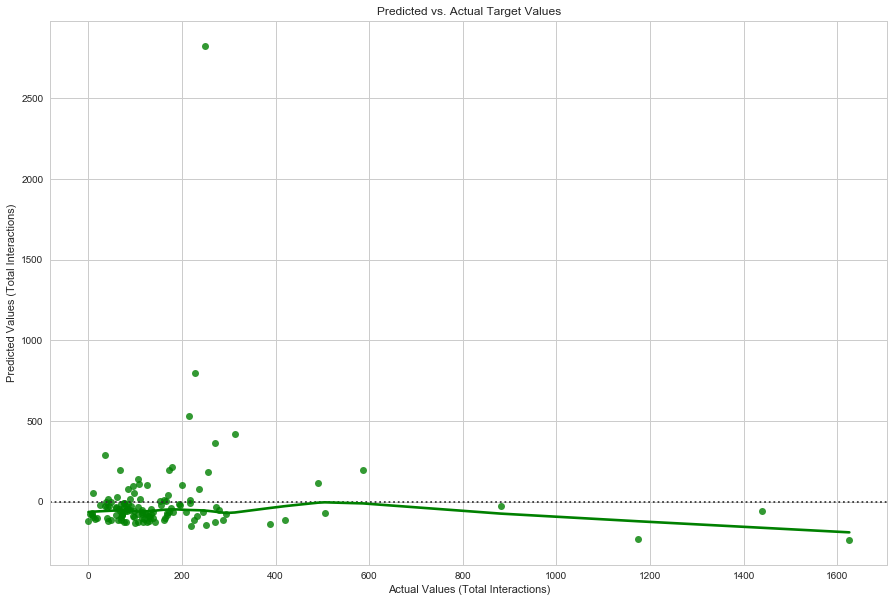

In [191]:
predictions = model.predict(x_test)

fig = plt.figure(figsize=(15,10))
sns.residplot(y_test, predictions, lowess=True, color="g")

plt.xlabel('Actual Values (Total Interactions)')
plt.ylabel('Predicted Values (Total Interactions)')
plt.title('Predicted vs. Actual Target Values')

This definitely looks like a better fit! If we look back at our correlation matrix, we can see there was one last variable that seemed correlated with Total Interactions. Let's see if adding that variable improves our score.

In [192]:
X = df[['Total Impressions from Liked Profiles', 'Lifetime Engaged Users', 'Lifetime Post Total Reach']]
Y = df['Total Interactions']
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42)

In [193]:
model = sm.OLS(y_train, x_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     Total Interactions   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     156.9
Date:                Tue, 05 Nov 2019   Prob (F-statistic):           1.03e-65
Time:                        01:47:31   Log-Likelihood:                -2689.2
No. Observations:                 375   AIC:                             5384.
Df Residuals:                     372   BIC:                             5396.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

Text(0.5,1,'Predicted vs. Actual Target Values')

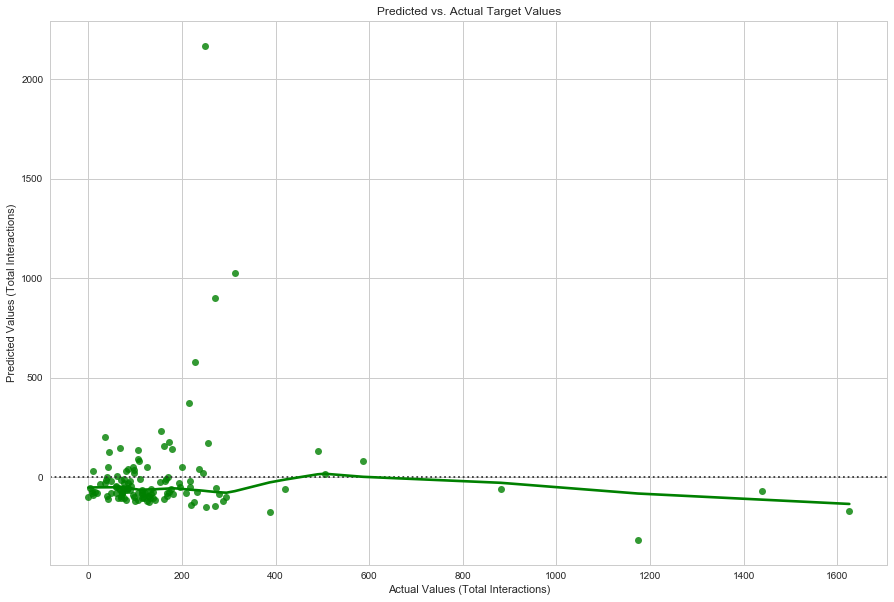

In [194]:
predictions = model.predict(x_test)

fig = plt.figure(figsize=(15,10))
sns.residplot(y_test, predictions, lowess=True, color="g")

plt.xlabel('Actual Values (Total Interactions)')
plt.ylabel('Predicted Values (Total Interactions)')
plt.title('Predicted vs. Actual Target Values')

Not as good as before! Our model with two variables had a more normally distributed residual plot than our model with three. Let's see if swapping out "Lifetime Post Impressions by people who have liked your Page" for "Lifetime Post Total Reach" improves our fit.

In [195]:
X = df[['Lifetime Engaged Users', 'Lifetime Post Total Reach']]
Y = df['Total Interactions']
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42)

In [196]:
model = sm.OLS(y_train, x_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     Total Interactions   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     221.2
Date:                Tue, 05 Nov 2019   Prob (F-statistic):           4.42e-64
Time:                        01:47:32   Log-Likelihood:                -2695.8
No. Observations:                 375   AIC:                             5396.
Df Residuals:                     373   BIC:                             5404.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Lifetime Engaged Users

Text(0.5,1,'Predicted vs. Actual Target Values')

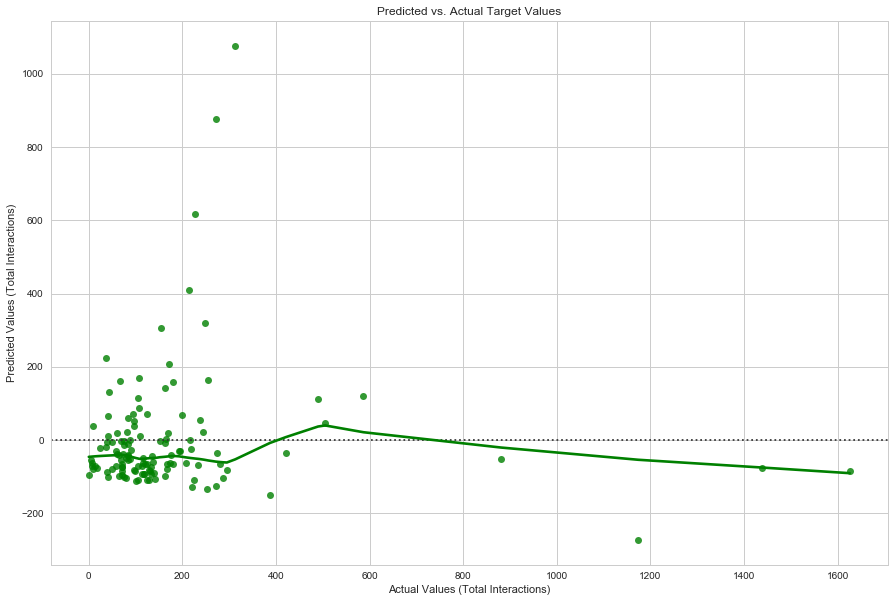

In [197]:
predictions = model.predict(x_test)

fig = plt.figure(figsize=(15,10))
sns.residplot(y_test, predictions, lowess=True, color="g")

plt.xlabel('Actual Values (Total Interactions)')
plt.ylabel('Predicted Values (Total Interactions)')
plt.title('Predicted vs. Actual Target Values')

Still looks like we're missing something! As it stands, it looks like the best model we had included 'Lifetime Post Impressions by people who have liked your Page' (which we renamed) and Lifetime Engaged Users. 

If we were presenting this to a C-Suite executive, we could perhaps point to those two variables as most significant.